# リアルタイム Parabolic SAR (rtpsar) デモ

## まとめてライブラリをインポート

In [1]:
import datetime
import re

from matplotlib import (
    dates as mdates,
    font_manager as fm,
    pyplot as plt,
    ticker as ticker,
)
import numpy as np
import pandas as pd

from rtpsar import RealTimePSAR

## 関数

In [2]:
def get_date_formatted(dateStr: str) -> str:
    pattern = re.compile(r'^([0-9]{4})([0-9]{2})([0-9]{2})$')
    m = pattern.match(dateStr)
    if m:
        return '%s-%s-%s' % (
            m.group(1),
            m.group(2),
            m.group(3),
        )
    else:
        return '1970-01-01'


def get_major_xticks(df: pd.DataFrame) -> tuple:
    date_str = str(df.index[0].date())
    tick_labels = [
        '9:00', '9:30', '10:00', '10:30', '11:00', '11:30', '12:00',
        '12:30', '13:00', '13:30', '14:00', '14:30', '15:00', '15:30',
    ]
    tick_position = [pd.to_datetime('%s %s' % (date_str, l)) for l in tick_labels]

    return tick_position, tick_labels


def get_tick4analysis(df: pd.DataFrame, dateFmt: str) -> pd.DataFrame:
    df.index = [pd.to_datetime('%s %s' % (dateFmt, df.iat[r, 0])) for r in range(len(df))]
    df.index.name = 'Datetime'
    df['Price'] = df['Price'].astype(float)

    return pd.DataFrame(df['Price'])

## 過去ログ (Tick) の読み込み

In [3]:
code = '8306'
dateStr = '20250313'
tick_excel = 'tick_%s_%s.xlsx' % (code, dateStr)
df = pd.read_excel(tick_excel)

# Tick データを Matplotlib で扱いやすいように整形
dateFmt = get_date_formatted(dateStr)
df = get_tick4analysis(df, dateFmt)
df

,Price
Datetime,
2025-03-13 09:00:00,1952.5
2025-03-13 09:00:01,1954.0
2025-03-13 09:00:04,1956.5
2025-03-13 09:00:05,1957.5
2025-03-13 09:00:07,1960.0
...,...
2025-03-13 15:24:54,1954.0
2025-03-13 15:24:56,1953.5
2025-03-13 15:24:58,1953.5


## RealTimePSAR インスタンス

リアルタイムで使用することを想定しているため、デモでは時刻と株価を順番に add メソッドでインスタンスに渡す。

In [4]:
af_init=0.0000
af_step=0.0005
af_max=0.05
psar = RealTimePSAR(af_init, af_step, af_max)

for r in range(len(df)):
    t = df.index[r]
    price = df.loc[t, 'Price']
    psar.add(t, price)

df_psar = psar.getPSAR()
df_psar

,Price,TREND,EP,AF,PSAR
Datetime,,,,,
2025-03-13 09:00:00,1952.5,0.0,NaN,NaN,NaN
2025-03-13 09:00:01,1954.0,1.0,1954.0,0.0000,1954.000000
2025-03-13 09:00:04,1956.5,1.0,1956.5,0.0005,1954.001250
2025-03-13 09:00:05,1957.5,1.0,1957.5,0.0010,1954.004749
2025-03-13 09:00:07,1960.0,1.0,1960.0,0.0015,1954.013742
...,...,...,...,...,...
2025-03-13 15:24:54,1954.0,-1.0,1953.0,0.0035,1957.054583
2025-03-13 15:24:56,1953.5,-1.0,1953.0,0.0035,1957.040392
2025-03-13 15:24:58,1953.5,-1.0,1953.0,0.0035,1957.026251


## チャート

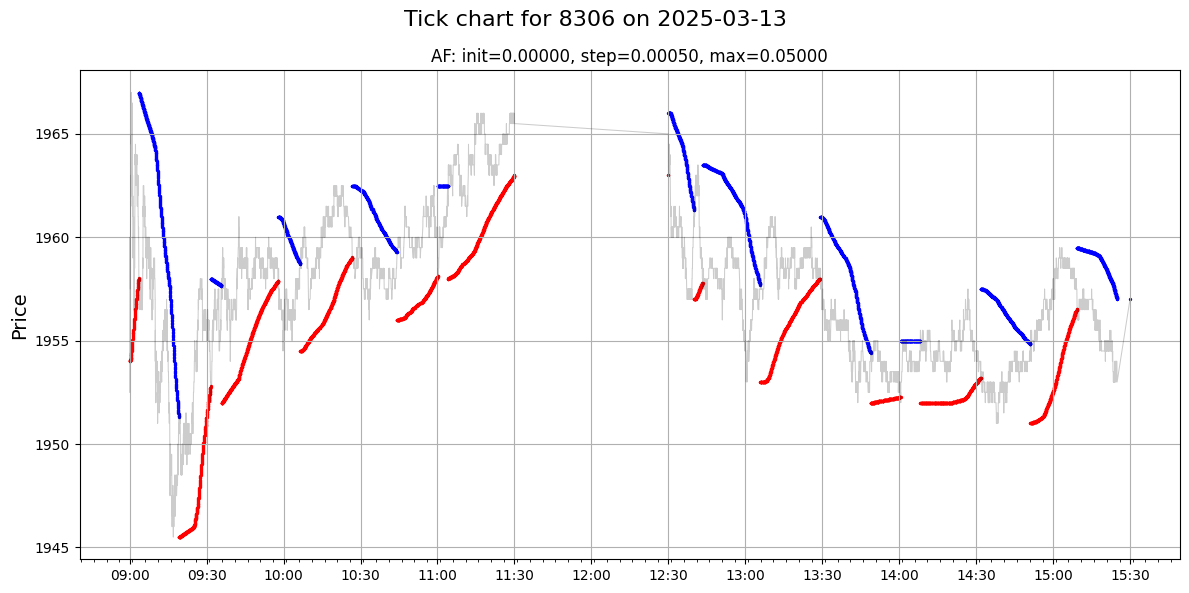

In [5]:
fig, ax = plt.subplots(figsize=(12, 6))

# Tick
ax.plot(df_psar['Price'], linewidth=0.75, color='black', alpha=0.2)

# PSAR bear - Downward trend
df_bear = df_psar[df_psar['TREND'] < 0]
ax.scatter(x=df_bear.index, y=df_bear['PSAR'], color='blue', s=2)

# PSAR bull - Upward trend
df_bull = df_psar[df_psar['TREND'] > 0]
ax.scatter(x=df_bull.index, y=df_bull['PSAR'], color='red', s=2)

tick_position, tick_labels = get_major_xticks(df)
ax.set_xticks(ticks=tick_position, labels=tick_labels,)
ax.xaxis.set_minor_locator(mdates.MinuteLocator(interval=5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_ylabel('Price', fontsize=14)
ax.grid()

ax.set_title('AF: init=%.5f, step=%.5f, max=%.5f' % (af_init, af_step, af_max))
suptitle = 'Tick chart for %s on %s' % (code, dateFmt)
plt.suptitle(suptitle, fontsize=16)

plt.tight_layout()
plt.savefig('screenshots/tick_chart_%s_%s.png' % (code, dateFmt))
plt.show()